# **Lab of Dimension Reduction from Glorie Metsa Wowo and Lena Monsch**

# 1.2: Load packages and prepare data

In [14]:
# load needed packages
from scipy.sparse import coo_matrix, csr_matrix
from scipy.sparse.linalg import svds
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

# import data
data = pd.read_csv('/content/ratings.csv')


# we only need first three columns:
data = data.iloc[:,:3]
print(data.head)

<bound method NDFrame.head of         userId  movieId  rating
0            1        1     4.0
1            1        3     4.0
2            1        6     4.0
3            1       47     5.0
4            1       50     5.0
...        ...      ...     ...
100831     610   166534     4.0
100832     610   168248     5.0
100833     610   168250     5.0
100834     610   168252     5.0
100835     610   170875     3.0

[100836 rows x 3 columns]>


In [15]:
# to work more efficiently with sparse data:

# which user/movie IDs are there?
user_ids = data['userId'].unique()
movie_ids = data['movieId'].unique()

# in which row/column are the user/movie IDs?
user_to_idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
movie_to_idx = {movie_id: idx for idx, movie_id in enumerate(movie_ids)}

# convert initial IDs to the corresponding matrix indeces
row_ind = data['userId'].map(user_to_idx)
col_ind = data['movieId'].map(movie_to_idx)

# apply functions to create efficient Y
data_coo = coo_matrix((data['rating'], (row_ind, col_ind)), shape = (610, 9724))
Y = csr_matrix(data_coo)

print(Y[:5, :5])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 8 stored elements and shape (5, 5)>
  Coords	Values
  (0, 0)	4.0
  (0, 1)	4.0
  (0, 2)	4.0
  (0, 3)	5.0
  (0, 4)	5.0
  (3, 3)	2.0
  (4, 0)	4.0
  (4, 4)	4.0


# 1.3: Preliminary Questions

1.   How is this problem related to the course? To which of the sparse linear regression algorithms (matching pursuit, iterative hard thresholding, convex relaxation) can you compare each of the three completion algorithms?

to do

---

2.  How does the error measure $||\hat{X}_r^S − Y^S ||_2^2$ behave as we increase the rank r? To what phenomenon is this related, and how can we prevent it?

(I'm not entirely confident with this answer, don't hesitate to add/change something if you see it differently)

Let's at first remember that $\hat{X}_r^S$ is computed as $\arg\min \limits_{rank(X)\leq r}||X^S − Y^S ||_2^2$.

By increasing the rank r, the set of possible matrices for $\hat{X}_r^S$ enlarges. This can result in the issue of overfitting, because $\hat{X}_r^S$ might now be able to be too close to Y. You can controll this issue by trying out different values for r. In the end, the most appropriate value for r is chosen by looking at the prediction error on new data, for example by conducting cross-validation.

---

3.  Plot the singular values of the matrix $Y^S$. What does the plot look like? What does this tell you about the rank of the matrix Y ?

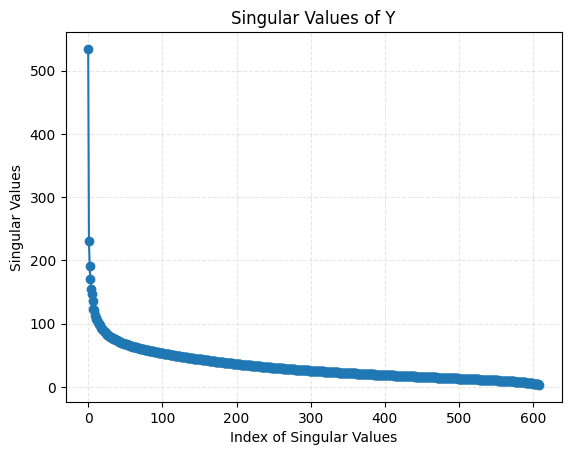

In [23]:
# compute the maximal k that is feasible for the function
k = min(Y.shape[0], Y.shape[1]) -1

# compute the singular values for sparse matrices
u, sigma, v = svds(Y, k=k)


# plot the singular values accordingly
plt.plot(sigma[::-1], 'o-')
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
plt.xlabel('Index of Singular Values')
plt.ylabel('Singular Values')
plt.title('Singular Values of Y')
plt.show()

The plotted curve of the resulting singular values decreases exponentially after approximately index 20. It thus shows that there are few singular values with a comparatively high value and very many with a comparatively low value. Consequently, the rank of matrix Y must be low, because its high-dimensional structure can very be approximated by few relevant singular values.

# 2: Implementation of the algorithms

In [ ]:
# define function to compute relative error more easily (compare 1.3 for definition)

def err(X,Y):
  res = np.linalg.norm(X-Y, ord=2)/np.linalg.norm(X, ord=2)
  return res

**2.1: Singular Value Projection (SVP)**

In [ ]:
def svp(S, Ys, r):

  # initialise results
  X = np.zeros((Ys.shape[0], Ys.shape[1]))

  # first stop criterium
  while err(X, Ys) > 0.01:

    # compute Xs by turning entries outside of S to 0
    Xs = X * S
    # compute X_{t+1/2}
    Xsvd = X + eta * (Ys - Xs)
    # compute SVD for sparse matrices up to order r
    U, Sigma, Vt = svds(Xsvd, k=r)
    # update X_t with inversed order (largest singular value first)
    Xnew = U[:, ::-1] @ Sigma[::-1] @ Vt[::-1, :]

    # second stop criterium after computing Xnew
    if(err(Xnew, Ys)> err(X, Ys)):
      break

    # make Xt+1 the next Xt for the next iteration
    X = Xnew

  # eventually return X_t, when while loop stops
  return Xnew

  ## LEARNING RATE NOT OPTIMIZED YET (currently eta)

**2.2: Singular Value Thresholding (SVT)**

In [ ]:
def svt(S, Ys):

  # initialise results
  X = np.zeros((Ys.shape[0], Ys.shape[1]))

  # first stop criterium
  while err(X, Ys) > 0.01:

    # compute Xs by turning entries outside of S to 0
    Xs = X * S
    # compute X_{t+1/2}
    Xsvd = X + eta * (Ys - Xs)
    # compute the maximal k that is feasible for the function
    k = min(Xsvd.shape[0], Xsvd.shape[1]) -1
    # compute SVD for sparse matrices for as many singular values as possible
    U, Sigma, Vt = svds(Xsvd, k=k)
    # compute S_lambda of Sigma
    S_lambda = np.sign(Sigma) * np.maximum(np.abs(Sigma) - lamb, 0)
    # update X_t with inversed order (largest singular value first)
    # and with soft thresholding operator
    Xnew = U[:, ::-1] @ S_lambda[::-1] @ Vt[::-1, :]

    # second stop criterium after computing Xnew
    if(err(Xnew, Ys)> err(X, Ys)):
      break

    # make Xt+1 the next Xt for the next iteration
    X = Xnew

  # eventually return X_t, when while loop stops
  return Xnew

  ## LEARNING RATE NOT OPTIMIZED YET (currently eta)
  # LAMBDA OF S_LAMBDA NEEDS TO BE CHOSEN (currently lamb)

**2.3: ADMiRA algorithm**

# Evaluation of the algorithms

**Application of the algorithms to the dataset to compare the relative error and computation time**